In [1]:
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adamax
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import concurrent.futures
import urllib.request
import os
import shutil
import csv
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import json

## Verifing if GPU is enable

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 100193726870732094
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3256483840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12705234995247380713
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 960M, pci bus id: 0000:02:00.0, compute capability: 5.0"
]


# Threat data

In [2]:
# dataset present in site https://data.world/crowdflower/image-sentiment-polarity/workspace/file?filename=image-Sentiment-polarity-DFE.csv
dataframe = pd.read_csv('image-Sentiment-polarity-DFE.csv')
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15613 entries, 0 to 15612
Data columns (total 10 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   _unit_id                                                                        15613 non-null  int64  
 1   _golden                                                                         15613 non-null  bool   
 2   _unit_state                                                                     15613 non-null  object 
 3   _trusted_judgments                                                              15613 non-null  int64  
 4   _last_judgment_at                                                               14999 non-null  object 
 5   which_of_these_sentiment_scores_does_the_above_image_fit_into_best              15613 non-null  object 
 6   which_of_these

In [3]:
dataframe

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,which_of_these_sentiment_scores_does_the_above_image_fit_into_best,which_of_these_sentiment_scores_does_the_above_image_fit_into_best:confidence,imageurl,which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold,which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold_reason
0,694550568,True,golden,47,NaN,Positive,0.6395,http://farm1.staticflickr.com/20/71235476_3103...,Highly positive\nPositive,"He is smiling. => happy, joy"
1,694550569,True,golden,36,NaN,Positive,0.6458,http://farm4.staticflickr.com/3096/2584485524_...,Highly positive\nPositive,A beautiful scenery. => serenity
2,694550570,True,golden,35,NaN,Negative,0.8420,http://farm3.staticflickr.com/2880/11733997835...,Negative\nHighly negative,"They look serious. => sadness, fear"
3,694550571,True,golden,41,NaN,Positive,0.7216,http://farm4.staticflickr.com/3022/2286937150_...,Highly positive\nPositive,"A cute puppy. => happy, joy"
4,694550572,True,golden,46,NaN,Positive,0.8801,http://farm1.staticflickr.com/163/357381033_d0...,Highly positive\nPositive,"She looks fun. => fun, joy, happy"
...,...,...,...,...,...,...,...,...,...,...
15608,694566363,False,finalized,3,3/26/15 1:59,Positive,0.6705,http://farm3.static.flickr.com/2198/1572103607...,NaN,NaN
15609,694566364,False,finalized,3,3/26/15 2:13,Positive,0.3373,http://farm1.static.flickr.com/100/263134442_6...,NaN,NaN
15610,694566365,False,finalized,3,3/26/15 2:54,Positive,0.6663,http://farm2.static.flickr.com/1360/1392747419...,NaN,NaN
15611,694566366,False,finalized,3,3/26/15 2:46,Negative,0.6760,http://farm3.static.flickr.com/2077/1925076121...,NaN,NaN


<AxesSubplot:>

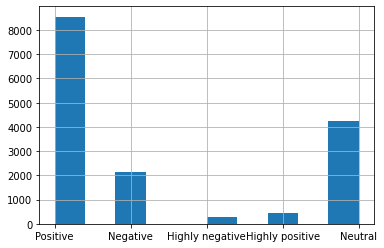

In [4]:
# histogram of positive and negative images
dataframe['which_of_these_sentiment_scores_does_the_above_image_fit_into_best'].hist()

In [7]:
sentimental_label_classify = dataframe[
    'which_of_these_sentiment_scores_does_the_above_image_fit_into_best'
]

In [8]:
sentimental_label_classify.unique()

array(['Positive', 'Negative', 'Highly negative', 'Highly positive',
       'Neutral'], dtype=object)

In [9]:
def plot_pie_chart_count_sentiments(sentiment_count):
    fig1, ax1 = plt.subplots()
    ax1.pie(
        sentiment_count.values(), 
        labels=list(sentiment_count.keys()), 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90
    )
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

### Distribution classify labels 

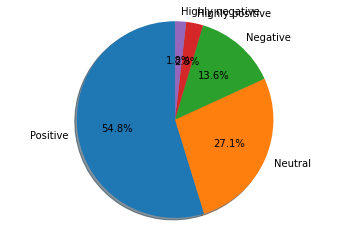

In [10]:
sentiment_count = dict(sentimental_label_classify.value_counts())
plot_pie_chart_count_sentiments(sentiment_count)

In [11]:
dataframe['sentiment'] = dataframe['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']
dataframe['sentiment'].replace({"Highly negative": "Negative", "Highly positive": "Positive"}, inplace=True)

In [12]:
dataframe['sentiment'].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

### Distribution after eliminate classify labels 

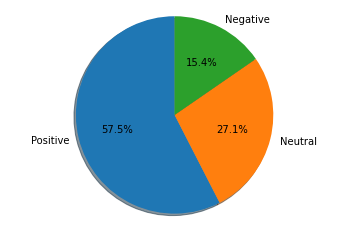

In [13]:
sentiment_count = dict(dataframe['sentiment'].value_counts())
plot_pie_chart_count_sentiments(sentiment_count)

In [24]:
X = dataframe['imageurl']
y = dataframe['sentiment']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=100)
# print(f"Training target statistics: {Counter(y_train)}")
# print(f"Testing target statistics: {Counter(y_test)}")

### Download dataset image

In [63]:
images_not_found = []
# create main directory
DATASET_MAIN_DIRECTORY = "dataset"
if not os.path.exists(DATASET_MAIN_DIRECTORY):
    os.makedirs(DATASET_MAIN_DIRECTORY)

# create label directories
for label in y.unique():
    if not os.path.exists(f"{DATASET_MAIN_DIRECTORY}/{label}"):
        os.makedirs(
            f"{DATASET_MAIN_DIRECTORY}/{label}"
        )

def download_image(kwargs):
    filename = kwargs['image_url'].split("/")[-1]
    try:
        urllib.request.urlretrieve(
            kwargs['image_url'], 
            f"{DATASET_MAIN_DIRECTORY}/{kwargs['label']}/{filename}"
        )
    except urllib.error.HTTPError:
        print(f"Not Found: {url}")
        images_not_found.append(url)
        
with concurrent.futures.ThreadPoolExecutor() as executor:
    #download images to directories
    for image_url, label_classified in zip(X, y):
        executor.submit(
            download_image, 
            {
                'image_url': image_url, 
                'label': label_classified
            }
    )        
    
with open('images_not_found.txt', 'w') as f:
    f.writelines(images_not_found)

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpgNot Found: http://far

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpgNot Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpgNot Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://farm1.static.flickr.com/76/159079785_718aa96d54.jpg
Not Found: http://fa

## Threat dataset from "http://www.t4sa.it/"

In [2]:
os.listdir("../b-t4sa_imgs")

['b-t4sa_test.txt',
 'data',
 'b-t4sa_train.txt',
 'b-t4sa_val.txt',
 'b-t4sa_all.txt']

In [3]:
labels = os.listdir("./dataset")

In [ ]:
label = {
    "0": "Negative",
    "1": "Neutral",
    "2": "Positive"
}

files = {
    "Negative": [],
    "Neutral": [],
    "Positive": []
}

with open('../b-t4sa_imgs/b-t4sa_all.txt') as f:
    lines = f.readlines()
    for line in lines:
        [path_img, classify] = line.replace("\n", "").split(" ")
        filename = path_img.split("/")[-1]
        shutil.move('../b-t4sa_imgs/' + path_img, f'./dataset/{label[classify]}/{filename}')
        files[label[classify]].append(filename)

In [ ]:
with open('image_dataset.csv', mode='w') as csv_file:
    fieldnames = ['filename', 'classifying']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    for key in list(files.keys()):
        for file in files[key]:
            writer.writerow(
                {
                    'filename': file, 
                    'classifying': key,
                }
            )

## Get all the merge data from dataset

In [3]:
labels = [
    "Negative",
    "Neutral",
    "Positive"
]

In [10]:
for i in labels:
    print(os.listdir(f'./dataset/{i}')[0])

796872088254615554-4.jpg
769583413728870402-1.jpg
783288675341926401-1.jpg


In [19]:
final_dataset = []
with open('final_image_dataset.csv', mode='w') as csv_file:
    fieldnames = ['filename', 'classifying']
    writer = csv.DictWriter(csv_file, fieldnames)
    writer.writerow({
        'filename': fieldnames[0],
        'classifying': fieldnames[-1]
    })
    for label in labels:
        for file in os.listdir(f'./dataset/{label}'):
            writer.writerow(
                {
                    'filename': file, 
                    'classifying': label,
                }
            )

In [5]:
df_final_dataset = pd.read_csv('final_image_dataset.csv')

In [6]:
X_final = df_final_dataset['filename']
y_final = df_final_dataset['classifying']

## Balancing the dataset

In [7]:
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_final.values.reshape(-1, 1), y_final)
X_train, X_test, y_train, y_test = train_test_split(
    X_res, 
    y_res, 
    test_size=0.25, 
    random_state=100
)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({'Neutral': 119336, 'Negative': 119151, 'Positive': 119107})
Testing target statistics: Counter({'Positive': 39824, 'Negative': 39780, 'Neutral': 39595})


Text(0.5, 1.0, 'Número de dados no dataset')

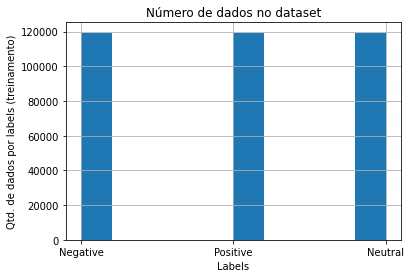

In [8]:
y_train.hist()
plt.ylabel('Qtd. de dados por labels (treinamento)')
plt.xlabel('Labels')
plt.title('Número de dados no dataset')

Text(0.5, 1.0, 'Número de dados no dataset')

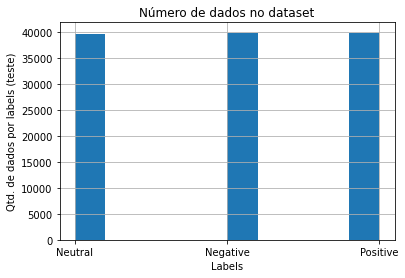

In [9]:
y_test.hist()
plt.ylabel('Qtd. de dados por labels (teste)')
plt.xlabel('Labels')
plt.title('Número de dados no dataset')

## Training model

In [3]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D
from keras.layers import BatchNormalization, Dropout, InputLayer,GlobalAveragePooling2D
from keras.preprocessing import image
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
# from keras.applications.resnet_v2 import preprocess_input, ResNet50V2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.models import Model
from keras import optimizers
import pandas as pd
import numpy as np
import keras
import os

In [4]:
# VARIABLES

# Number of classes [Negative, Neutral, Positive]
NUM_CLASSES = 3

# Channels for all classes
CHANNELS = 3

IMAGE_RESIZE = 224
# IMAGE_WIDTH = 300
# IMAGE_HEIGHT = 300
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

STEPS_PER_EPOCH = 10

BATCH_SIZE_TRAINING = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [12]:
shape = (IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=shape)
output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(resnet.input, output)

for layer in restnet.layers:
    layer.trainable = False

resnet.summary()

94773248/94765736 [==============================] - 8s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [13]:
# model = Sequential()
# model.add(restnet)
# model.add(Dense(512, activation='relu', input_dim=shape))
# model.add(Dropout(0.3))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy',
#               optimizer=optimizers.RMSprop(lr=2e-5),
#               metrics=['accuracy'])
# model.summary()
x = keras.layers.Flatten()(restnet.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(3, activation='softmax')(x)
full_model = keras.models.Model(inputs=resnet.input, outputs=predictions)
full_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

## Dealing files

In [6]:
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datasetdir = '/tf/notebooks/image_classifier/dataset'
os.chdir(datasetdir)

batch_size = 15

In [46]:
def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = tuple(labels),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = tuple(labels),
        batch_size = batch_size,
        subset = 'validation'
    )
    
    return train_dataset, val_dataset

In [6]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [9]:
train_dataset, val_dataset = generators((224,224), preprocessing=preprocess_input)

NameError: name 'labels' is not defined

In [21]:
full_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adamax(lr=0.001),
    metrics=['acc']
)

history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=5,
)

Epoch 1/5
14496/14496 [==============================] - 6756s 466ms/step - loss: 0.5854 - acc: 0.4990 - val_loss: 0.6008 - val_acc: 0.4755
Epoch 2/5
14496/14496 [==============================] - 6632s 457ms/step - loss: 0.5709 - acc: 0.5216 - val_loss: 0.6016 - val_acc: 0.4670
Epoch 3/5
14496/14496 [==============================] - 6621s 457ms/step - loss: 0.5592 - acc: 0.5380 - val_loss: 0.6049 - val_acc: 0.4768
Epoch 4/5
14496/14496 [==============================] - 6620s 456ms/step - loss: 0.5463 - acc: 0.5554 - val_loss: 0.6079 - val_acc: 0.4729
Epoch 5/5
14496/14496 [==============================] - 6643s 458ms/step - loss: 0.5318 - acc: 0.5741 - val_loss: 0.6160 - val_acc: 0.4696


In [ ]:
plot_history(history, yrange=(0.9,1))

In [23]:
full_model.save('resnet50_image_sentimental_classification.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Second Test

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datasetdir = '/tf/notebooks/image_classifier/dataset_minify'
os.chdir(datasetdir)

In [13]:
base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
labels = [
    "Negative",
    "Neutral",
    "Positive"
]
train_dataset, val_dataset = generators((224,224), preprocessing=preprocess_input)

Found 8103 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [14]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.RMSprop(lr=2e-5),
    metrics=['accuracy'],
)

history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=5,
    epochs=15,
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
541/541 [==============================] - 406s 722ms/step - loss: 0.6322 - accuracy: 0.4333 - val_loss: 0.6504 - val_accuracy: 0.4278
Epoch 2/15
541/541 [==============================] - 389s 718ms/step - loss: 0.5364 - accuracy: 0.5882 - val_loss: 0.6746 - val_accuracy: 0.4056
Epoch 3/15
541/541 [==============================] - 390s 719ms/step - loss: 0.4443 - accuracy: 0.6999 - val_loss: 0.7357 - val_accuracy: 0.4422
Epoch 4/15
541/541 [==============================] - 389s 719ms/step - loss: 0.3298 - accuracy: 0.8133 - val_loss: 0.9159 - val_accuracy: 0.4067
Epoch 5/15
541/541 [==============================] - 389s 718ms/step - loss: 0.2130 - accuracy: 0.8925 - val_loss: 1.2311 - val_accuracy: 0.4278
Epoch 6/15
541/541 [==============================] - 389s 717ms/step - loss: 0.1410 - accuracy: 0.9347 - val_loss: 1.5095 - val_accuracy: 0.4311
Epoch 7/15
541/541 [==============================] - 390s 719ms/step - loss: 0.0930 - accuracy: 0.9590 - val_loss: 1.8600 -

In [19]:
model.save('model-')

## Third Test

In [15]:
datasetdir = '/tf/notebooks/image_classifier/dataset_minify'
os.chdir(datasetdir)

batch_size = 15

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=predictions)

94773248/94765736 [==============================] - 35s 0us/step


In [16]:
labels = [
    "Negative",
    "Neutral",
    "Positive"
]
train_dataset, val_dataset = generators((224,224), preprocessing=preprocess_input)

Found 8103 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [18]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adamax(lr=0.001),
    metrics=['acc']
)

history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=15,
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
541/541 [==============================] - 423s 713ms/step - loss: 0.6470 - acc: 0.4126 - val_loss: 0.8551 - val_acc: 0.4000
Epoch 2/15
541/541 [==============================] - 386s 712ms/step - loss: 0.6136 - acc: 0.4432 - val_loss: 0.6258 - val_acc: 0.4078
Epoch 3/15
541/541 [==============================] - 386s 711ms/step - loss: 0.6076 - acc: 0.4608 - val_loss: 0.6877 - val_acc: 0.3822
Epoch 4/15
541/541 [==============================] - 383s 707ms/step - loss: 0.6038 - acc: 0.4682 - val_loss: 0.6647 - val_acc: 0.3933
Epoch 5/15
541/541 [==============================] - 386s 711ms/step - loss: 0.5987 - acc: 0.4759 - val_loss: 0.6420 - val_acc: 0.3711
Epoch 6/15
541/541 [==============================] - 386s 712ms/step - loss: 0.5889 - acc: 0.4971 - val_loss: 0.6518 - val_acc: 0.4111
Epoch 7/15
541/541 [==============================] - 382s 704ms/step - loss: 0.5670 - acc: 0.5286 - val_loss: 0.6884 - val_acc: 0.3544
Epoch 8/15
541/541 [============================

In [19]:
model.save('model-resnet50-third-try.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Fourth Test

In [12]:
datasetdir = '/tf/notebooks/image_classifier/dataset_minify'
os.chdir(datasetdir)

batch_size = 15

base_model = ResNet50(weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
labels = [
    "Negative",
    "Neutral",
    "Positive"
]
train_dataset, val_dataset = generators((224,224), preprocessing=preprocess_input)

Found 8103 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [14]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adamax(lr=0.001),
    metrics=['acc']
)

history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=50,
)

Epoch 1/50
541/541 [==============================] - 141s 255ms/step - loss: 0.7112 - acc: 0.3368 - val_loss: 0.6662 - val_acc: 0.3900
Epoch 2/50
541/541 [==============================] - 138s 253ms/step - loss: 0.6530 - acc: 0.3447 - val_loss: 0.6627 - val_acc: 0.3422
Epoch 3/50
541/541 [==============================] - 142s 261ms/step - loss: 0.6482 - acc: 0.3395 - val_loss: 0.6521 - val_acc: 0.4033
Epoch 4/50
541/541 [==============================] - 150s 274ms/step - loss: 0.6446 - acc: 0.3446 - val_loss: 0.6497 - val_acc: 0.3344
Epoch 5/50
541/541 [==============================] - 148s 271ms/step - loss: 0.6423 - acc: 0.3481 - val_loss: 0.6440 - val_acc: 0.3889
Epoch 6/50
541/541 [==============================] - 151s 276ms/step - loss: 0.6362 - acc: 0.3767 - val_loss: 0.6367 - val_acc: 0.4089
Epoch 7/50
541/541 [==============================] - 149s 273ms/step - loss: 0.6312 - acc: 0.3982 - val_loss: 0.6310 - val_acc: 0.4433
Epoch 8/50
541/541 [============================

In [15]:
model.save('model-resnet50-fifth-try.h5')

## Create dataset minify

In [5]:
import os 
import shutil
import random

In [12]:
#     "Neutral",
labels = [
    "Negative",
    "Positive"
]


SRC_DIRECTORY = "/tf/notebooks/image_classifier/dataset"
ORIGIN_DIRECTORY = "/tf/notebooks/image_classifier/dataset_minify_binary"

SIZE_PER_LABEL = 10000

for label in labels:
    for c_file in os.listdir(f"{SRC_DIRECTORY}/{label}")[0:SIZE_PER_LABEL]:
        shutil.copy(
            f"{SRC_DIRECTORY}/{label}/{c_file}", 
            f"{ORIGIN_DIRECTORY}/{label}/{c_file}",
        )

In [13]:
len(os.listdir("/tf/notebooks/image_classifier/dataset_minify_binary/Negative"))

10000

## 6th try

In [7]:
datasetdir = '/tf/notebooks/image_classifier/dataset_minify_binary'
os.chdir(datasetdir)

batch_size = 20

def define_model():
    base_model = ResNet50(weights='imagenet', include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    # and a logistic layer -- let's say we have 3 classes
    predictions = Dense(3, activation='softmax')(x) 
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [18]:
def define_model_7th_try():
    shape = (224, 224, CHANNELS)
    resnet = ResNet50(
        include_top=False, 
        weights='imagenet', 
        input_shape=shape
    )

    for layer in resnet.layers:
        layer.trainable = False

    x = resnet.output
    x = AveragePooling2D(pool_size=(4, 4))(x)
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.5)(x)
    # x = Dense(units=400, activation='relu')(x)
    # x = Dropout(0.5)(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Negative or Positive
    predictions = Dense(2, activation='softmax')(x) 
    model = Model(inputs=resnet.input, outputs=predictions)
    return model

In [47]:
shape = (112, 112)

train_dataset, val_dataset = generators(shape, preprocessing=preprocess_input)

Found 16203 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


In [48]:
model = define_model()
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adamax(lr=0.001),
    metrics=['acc']
)

history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=70,
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/70
1081/1081 [==============================] - 146s 108ms/step - loss: 0.6953 - acc: 0.3343 - val_loss: 0.6618 - val_acc: 0.3572
Epoch 2/70
1081/1081 [==============================] - 116s 106ms/step - loss: 0.6492 - acc: 0.3307 - val_loss: 0.6532 - val_acc: 0.3361
Epoch 3/70
1081/1081 [==============================] - 117s 106ms/step - loss: 0.6435 - acc: 0.3499 - val_loss: 0.6465 - val_acc: 0.3367
Epoch 4/70
1081/1081 [==============================] - 117s 107ms/step - loss: 0.6402 - acc: 0.3620 - val_loss: 0.6407 - val_acc: 0.3561
Epoch 5/70
1081/1081 [==============================] - 115s 106ms/step - loss: 0.6368 - acc: 0.3725 - val_loss: 0.6354 - val_acc: 0.3661
Epoch 6/70
1081/1081 [==============================] - 116s 107ms/step - loss: 0.6324 - acc: 0.3956 - val_loss: 0.6274 - val_acc: 0.4250
Epoch 7/70
1081/1081 [==============================] - 116s 106ms/step - loss: 0.6275 - acc: 0.4150 - val_loss: 0.6270 - val_acc: 0.4061
Epoch 8/70
1081/1081 [============

1081/1081 [==============================] - 118s 108ms/step - loss: 0.1420 - acc: 0.9183 - val_loss: 1.3589 - val_acc: 0.4039
Epoch 61/70
1081/1081 [==============================] - 115s 106ms/step - loss: 0.1391 - acc: 0.9200 - val_loss: 1.3017 - val_acc: 0.4033
Epoch 62/70
1081/1081 [==============================] - 126s 115ms/step - loss: 0.1339 - acc: 0.9208 - val_loss: 1.4535 - val_acc: 0.4083
Epoch 63/70
1081/1081 [==============================] - 119s 109ms/step - loss: 0.1334 - acc: 0.9224 - val_loss: 1.3715 - val_acc: 0.4006
Epoch 64/70
1081/1081 [==============================] - 112s 103ms/step - loss: 0.1274 - acc: 0.9261 - val_loss: 1.4385 - val_acc: 0.3967
Epoch 65/70
1081/1081 [==============================] - 111s 102ms/step - loss: 0.1268 - acc: 0.9251 - val_loss: 1.5055 - val_acc: 0.4006
Epoch 66/70
1081/1081 [==============================] - 112s 103ms/step - loss: 0.1180 - acc: 0.9306 - val_loss: 1.3681 - val_acc: 0.3978
Epoch 67/70
1081/1081 [================

In [49]:
model.save('model-resnet50-6th-try.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [97]:
file = os.listdir(f"{SRC_DIRECTORY}/Negative")[-100]

In [71]:
label

'Positive'

In [55]:
f"{SRC_DIRECTORY}/{label}/784370910648229889-1.jpg"

'/tf/notebooks/image_classifier/dataset/Positive/784370910648229889-1.jpg'

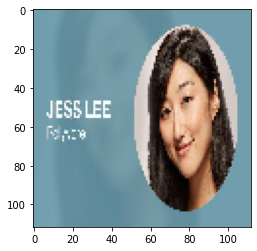

In [81]:
IMG_SIZE = 112

image_path=f"{SRC_DIRECTORY}/Positive/784370910648229889-1.jpg"
img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
# result=model.predict(img)
# print(max(result[0]))
# plt.title(get_label_name(result[0][0]))
# plt.show()

## Creating Dataframe to dataset minify

In [17]:
data_labels_minify = []

#     "Neutral",
labels = [
    "Negative",
    "Positive"
]

for label in labels:
    path_images = f'{ORIGIN_DIRECTORY}/{label}'
    for image_filename in os.listdir(path_images):
        data_labels_minify.append({
            'filename': image_filename,
            'path_image': f'{path_images}/{image_filename}',
            'label_target': label,
            'class_target': labels.index(label)
        })

random.shuffle(data_labels_minify)

df_dataset_minify = pd.DataFrame(data_labels_minify)

In [18]:
df_dataset_minify.head()

,filename,path_image,label_target,class_target
0,796101200349233152-1.jpg,/tf/notebooks/image_classifier/dataset_minify_...,Negative,0
1,783654661949628417-1.jpg,/tf/notebooks/image_classifier/dataset_minify_...,Positive,1
2,780594145417105408-1.jpg,/tf/notebooks/image_classifier/dataset_minify_...,Negative,0
3,782794888333127680-1.jpg,/tf/notebooks/image_classifier/dataset_minify_...,Negative,0
4,797404035062124545-1.jpg,/tf/notebooks/image_classifier/dataset_minify_...,Negative,0


In [19]:
df_dataset_minify.to_csv('dataset_minify_dataframe.csv', index=True)

In [20]:
df_dataset_minify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   filename      20000 non-null  object
 1   path_image    20000 non-null  object
 2   label_target  20000 non-null  object
 3   class_target  20000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 625.1+ KB


In [9]:
df_dataset_minify = pd.read_csv('dataset_minify_dataframe.csv')
# removing neutrals
# df_dataset_minify = df_dataset_minify.drop(
#     df_dataset_minify[df_dataset_minify.class_target == 0].index
# )
df_dataset_minify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   filename      20000 non-null  object
 2   path_image    20000 non-null  object
 3   label_target  20000 non-null  object
 4   class_target  20000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 781.4+ KB


In [10]:
SEED = 42
kfold = StratifiedKFold(
    n_splits=5,
    random_state=SEED,
    shuffle=True
)

df_minify_X = df_dataset_minify[['filename', 'path_image', 'label_target']]
df_minify_Y = df_dataset_minify[['class_target']]

In [6]:
def generators_by_dataframe(shape, values_df): 
    '''Create the training and validation datasets based in dataframe.
    '''
    batch_size = 10
#    "Neutral",
    labels = [
        "Negative",
        "Positive"
    ]
    
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        horizontal_flip = True, 
        validation_split = 0.2,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_dataframe(
        values_df,
        x_col='path_image', 
        y_col='label_target',
        target_size = (height, width), 
        batch_size = batch_size,
        subset='training'
    )

    val_dataset = imgdatagen.flow_from_dataframe(
        values_df,
        x_col='path_image', 
        y_col='label_target',
        target_size = (height, width), 
        classes = tuple(labels),
        batch_size = batch_size,
        subset='validation'
    )
    
    return train_dataset, val_dataset

In [7]:
def predict_images_transform(images_data):
    IMG_SIZE = 224
    images_stack = []
    for img_path in images_data['path_image']:
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img = np.expand_dims(img, axis=0)
        images_stack.append(img)
        
    return np.vstack(images_stack)

def transform_values_serie(classes):
    result = []
    for classe in classes:
        result.append(np.argmax(classe))
    return pd.Series(result)

# Traning model first time

In [11]:
total_df = 20000
number_test = round(total_df * 0.2)
SHAPE = (224, 224)

middle = total_df - number_test
main_df = df_dataset_minify[0:middle]
test_df = df_dataset_minify[middle:total_df]
gen_train, gen_valid = generators_by_dataframe(SHAPE, main_df)

model = define_model_7th_try()

opt = keras.optimizers.SGD(
    learning_rate=0.001, 
    momentum=0.9,
)

# opt = keras.optimizers.RMSprop(
#     learning_rate=0.001,
#     rho=0.9,
#     epsilon=1e-07,
# )

# optimizer=Adamax(learning_rate=0.0001),

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

cb_early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=30
)

cb_model_checkpoint = ModelCheckpoint(
    filepath='best_model_train.h5',
    monitor='val_accuracy', 
    mode='max', 
    restore_best_weights=True,
    save_best_only=True,
    verbose=1,
)

history = model.fit(
    gen_train, 
    validation_data = gen_valid,
    workers=5,
    epochs=150,
    callbacks=[cb_early_stopping, cb_model_checkpoint]
)

teste_df_transform = predict_images_transform(test_df)

y_pred = model.predict(teste_df_transform)

y_pred = transform_values_serie(y_pred)

data_report = classification_report(
    y_pred=y_pred, 
    y_true=test_df['class_target'], 
    output_dict=True,
    zero_division=1
)

file_json = f'/tf/notebooks/image_classifier/main_model_result.json'
with open(file_json, 'w+') as f:
    json.dump(data_report, f)
    f.close()

model.save(f'/tf/notebooks/image_classifier/main_model.h5')
print('Finish!')

Found 12800 validated image filenames belonging to 2 classes.
Found 3200 validated image filenames belonging to 2 classes.
Epoch 1/150
1280/1280 [==============================] - 306s 235ms/step - loss: 0.7464 - accuracy: 0.5107 - val_loss: 0.6925 - val_accuracy: 0.4938

Epoch 00001: val_accuracy improved from -inf to 0.49375, saving model to best_model_train.h5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/150
1280/1280 [==============================] - 299s 234ms/step - loss: 0.6971 - accuracy: 0.5098 - val_loss: 0.6916 - val_accuracy: 0.5134

Epoch 00002: val_accuracy improved from 0.49375 to 0.51344, saving model to best_model_train.h5
Epoch 3/150
1280/1280 [==============================] - 296s 231ms/step - loss: 0.6952 - accuracy: 0.5180 - val_loss: 0.6871 - val_accuracy: 0.5619

Epoch 00003: val_accuracy improved from 0.51344 to 0.56187, saving model to best_model_train.h5
Epoch 4/150
1280/1280 [==============================] - 299s 233ms/step - loss: 0.6898 - accuracy: 0.5332 - val_loss: 0.6837 - val_accuracy: 0.5653

Epoch 00004: val_accuracy improved from 0.56187 to 0.56531, saving model to best_model_train.h5
Epoch 5/150
1280/1280 [==============================] - 299s 234ms/step - loss: 0.6882 - accuracy: 0.5395 - val_loss: 0.6824 - val_accuracy: 0.5897

Epoch 00005: val_accuracy improved from 0.56531 to 0.58969, saving model to best_model_train.h5
Epoch 6/150
1280

KeyboardInterrupt: 

In [23]:
total_df = 20000
number_test = round(total_df * 0.2)
SHAPE = (224, 224)

middle = total_df - number_test
main_df = df_dataset_minify[0:middle]
test_df = df_dataset_minify[middle:total_df]
current_model = define_model_7th_try()
current_model.load_weights(
    '/tf/notebooks/image_classifier/best_model_train.h5'
)

teste_df_transform = predict_images_transform(test_df)
y_pred = load_model.predict(teste_df_transform)
y_pred = transform_values_serie(y_pred)

data_report = classification_report(
    y_pred=y_pred, 
    y_true=test_df['class_target'], 
    output_dict=True,
    zero_division=1
)
data_report

file_json = f'/tf/notebooks/image_classifier/main_model_result.json'
with open(file_json, 'w+') as f:
    json.dump(data_report, f)
    f.close()

current_model.save(f'/tf/notebooks/image_classifier/main_model.h5')
print('Finish!')

passou
passou aqui


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Finish!


In [12]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

### separate kfold train and test and save it on file to do cross val. during the week

In [78]:
data_kfold = {}
current_count = 0
for train, test in kfold.split(df_minify_X, df_minify_Y):
    data_kfold[current_count] = {
        'train': train.tolist(),
        'test': test.tolist()  
    }  
    current_count += 1

with open('/tf/notebooks/image_classifier/distribution_kfold.json', 'w+') as f:
    json.dump(data_kfold, f)
    f.close()

9601
2401
9601
2401
9602
2400
9602
2400
9602
2400


### load and training values

In [71]:
kfold_data = {}
with open('/tf/notebooks/image_classifier/distribution_kfold.json', 'r') as f:
    kfold_data = json.load(f)
    f.close()
print(len(kfold_data[str(0)]['train']))
print(len(kfold_data[str(0)]['train']))

9601
9601


In [79]:
SHAPE = (112, 112)

# for fold_epoch in range(6):
fold_epoch = 0
for train, test in kfold.split(df_minify_X, df_minify_Y):
#     train_values = np.array(kfold_data[str(fold_epoch)]['train'])
#     test_values = np.array(kfold_data[str(fold_epoch)]['test'])

    main_df = df_dataset_minify.iloc[train]
    test_df = df_dataset_minify.iloc[test]
    gen_train, gen_valid = generators_by_dataframe(SHAPE, main_df)

    model = define_model_7th_try()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adamax(learning_rate=0.0001),
        metrics=['accuracy']
    )

    history = model.fit(
        gen_train, 
        validation_data = gen_valid,
        workers=10,
        epochs=50,
    )

    teste_df_transform = predict_images_transform(test_df)

    y_pred = model.predict(teste_df_transform)

    y_pred = transform_values_serie(y_pred)

    data_report = classification_report(
        y_pred=y_pred, 
        y_true=test_df['class_target'], 
        output_dict=True,
        zero_division=1
    )

    file_json = f'/tf/notebooks/image_classifier/KFold/report_fold_{fold_epoch}.json'
    fold_epoch += 1
    with open(file_json, 'w+') as f:
        json.dump(data_report, f)
        f.close()

    model.save(f'/tf/notebooks/image_classifier/Models/model-kfold-{fold_epoch}-epoch-try.h5')

Found 8641 validated image filenames belonging to 2 classes.
Found 480 validated image filenames belonging to 2 classes.
Epoch 1/50
865/865 [==============================] - 79s 87ms/step - loss: 1.2531 - accuracy: 0.5128 - val_loss: 0.6939 - val_accuracy: 0.4875
Epoch 2/50
865/865 [==============================] - 73s 84ms/step - loss: 0.9452 - accuracy: 0.5128 - val_loss: 0.7056 - val_accuracy: 0.3604
Epoch 3/50
865/865 [==============================] - 74s 84ms/step - loss: 0.8447 - accuracy: 0.5013 - val_loss: 0.7001 - val_accuracy: 0.3938
Epoch 4/50
865/865 [==============================] - 73s 84ms/step - loss: 0.7892 - accuracy: 0.5062 - val_loss: 0.7018 - val_accuracy: 0.3125
Epoch 5/50
865/865 [==============================] - 74s 84ms/step - loss: 0.7526 - accuracy: 0.5124 - val_loss: 0.7022 - val_accuracy: 0.2958
Epoch 6/50
865/865 [==============================] - 74s 84ms/step - loss: 0.7376 - accuracy: 0.5111 - val_loss: 0.7063 - val_accuracy: 0.1771
Epoch 7/50
865/

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Found 8641 validated image filenames belonging to 2 classes.
Found 480 validated image filenames belonging to 2 classes.
Epoch 1/50
865/865 [==============================] - 76s 84ms/step - loss: 1.3492 - accuracy: 0.5040 - val_loss: 0.6985 - val_accuracy: 0.4688
Epoch 2/50
865/865 [==============================] - 72s 82ms/step - loss: 0.9860 - accuracy: 0.4931 - val_loss: 0.6851 - val_accuracy: 0.5958
Epoch 3/50
865/865 [==============================] - 72s 83ms/step - loss: 0.8556 - accuracy: 0.5039 - val_loss: 0.6786 - val_accuracy: 0.6833
Epoch 4/50
633/865 [====================>.........] - ETA: 17s - loss: 0.7980 - accuracy: 0.5105

KeyboardInterrupt: 

In [55]:
define_model_7th_try()